# Brain Stroke prediction

In [1]:
import pandas as pd
import graphviz
import random
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn import tree

In [2]:
RND_SEED = 123
def seed_everything(seed=RND_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()

## Reading data and initial analysis

In [3]:
df = pd.read_csv("brain_stroke.csv")
print(df.shape)
df.head()

(4981, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


We need to modify `gender`, `ever_married`, `work_type`, `residence_type` and `smoking_status` to one-hot encoded values.

In [4]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
gender,2
age,104
hypertension,2
heart_disease,2
ever_married,2
work_type,4
Residence_type,2
avg_glucose_level,3895
bmi,342
smoking_status,4


`avg_glucose_level` is almost unique per entry, so we have to watch out against overfitting

In [5]:
true_vals = sum(df['stroke'] == 1)
print("Strokes:", true_vals)
print("All cases:", len(df))
print("Stroke participation:", true_vals/len(df))

Strokes: 248
All cases: 4981
Stroke participation: 0.049789198956032926


In [6]:
df[['age', 'avg_glucose_level', 'bmi']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,4981.0,43.419859,22.662755,0.08,25.00,45.00,61.00,82.00
avg_glucose_level,4981.0,105.943562,45.075373,55.12,77.23,91.85,113.86,271.74
bmi,4981.0,28.498173,6.790464,14.00,23.70,28.10,32.60,48.90


In [7]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

It appears as if we don't have any missing data.

## Preparing data

In [8]:
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0


We indeed have some missing data in form of `smoking_status_Unknown`. Let's further clean the data.

In [9]:
df = df.drop(columns=['ever_married_No', 'smoking_status_Unknown', 'gender_Male'])
df = df.rename(columns={"ever_married_Yes": "ever_married", "gender_Female": "is_female"})
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,is_female,ever_married,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,1,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,1,1,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,0,0,1,1,0,0


In [10]:
TRAIN_FRAC = 0.8
train=df.sample(frac=TRAIN_FRAC,random_state=RND_SEED)
test=df.drop(train.index)

In [11]:
train_X = train.drop(columns=['stroke'])
train_Y = train[['stroke']]

test_X = test.drop(columns=['stroke'])
test_Y = test[['stroke']]

In [12]:
print(train_X.shape)
train_X.head()

(3985, 16)


,age,hypertension,heart_disease,avg_glucose_level,bmi,is_female,ever_married,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2017,56.0,0,0,96.93,25.0,0,1,0,1,0,0,0,1,0,0,1
4831,52.0,0,0,226.70,33.1,0,1,0,1,0,0,0,1,0,0,1
2524,70.0,1,1,93.62,35.8,0,1,0,1,0,0,1,0,0,1,0
3282,13.0,0,0,73.76,26.7,1,0,0,1,0,0,1,0,0,0,0
1450,33.0,0,0,78.34,25.5,1,0,0,1,0,0,0,1,0,1,0


# Models

Since our data is not balanced, let's calculate class-rebalancing.

In [13]:
weights = train_Y.copy()
weights[train_Y["stroke"] == 0] = sum(train_Y["stroke"]) / len(train_Y)
weights.head(10)

,stroke
2017,0.049937
4831,0.049937
2524,0.049937
3282,0.049937
1450,0.049937
3608,0.049937
30,1.000000
248,0.049937
3098,0.049937
193,1.000000


### Linear Regression Model (sklearn)

In [14]:
seed_everything()
reg_model = LinearRegression().fit(train_X, train_Y, weights["stroke"])

In [15]:
reg_model.coef_

array([[ 0.01448618,  0.09548367,  0.04966676,  0.00070854,  0.00105424,
        -0.00419043, -0.05135987, -0.07347577, -0.04111075, -0.07016107,
         0.18474759, -0.01406643,  0.01406643, -0.022403  , -0.05602687,
         0.02020475]])

According to linear-regression model, the highest impact on the likelihood of having a stroke has variable work_type_children. Another positively correlated variables are hypertension and heart_disease.
On the other hand to limit the likelihood of having a stroke, one should - be self-employed or work in govermental job, have never smoked and be married.

In [16]:
pred = reg_model.predict(test_X)
pred_bin = pred > 0.5
print("Accuracy:", accuracy_score(y_true = test_Y, y_pred = pred_bin))
print("ROC AUC Score:", roc_auc_score(y_true = test_Y, y_score = pred))
print(confusion_matrix(y_true = test_Y, y_pred = pred_bin))

Accuracy: 0.7259036144578314
ROC AUC Score: 0.8403766997823416
[[680 267]
 [  6  43]]


As one can see, has worse accuracy than saying no-stroke at all times, but what we care is how successful we are in detecting stroke. In our case we have a lot of false-positives. We have around 88% accuracy in detecting stroke if user has a stroke.

### Decision Tree

In [17]:
seed_everything()
tree_model = tree.DecisionTreeClassifier(class_weight={0: sum(train_Y["stroke"]) / len(train_Y), 1:1}).fit(train_X, train_Y)

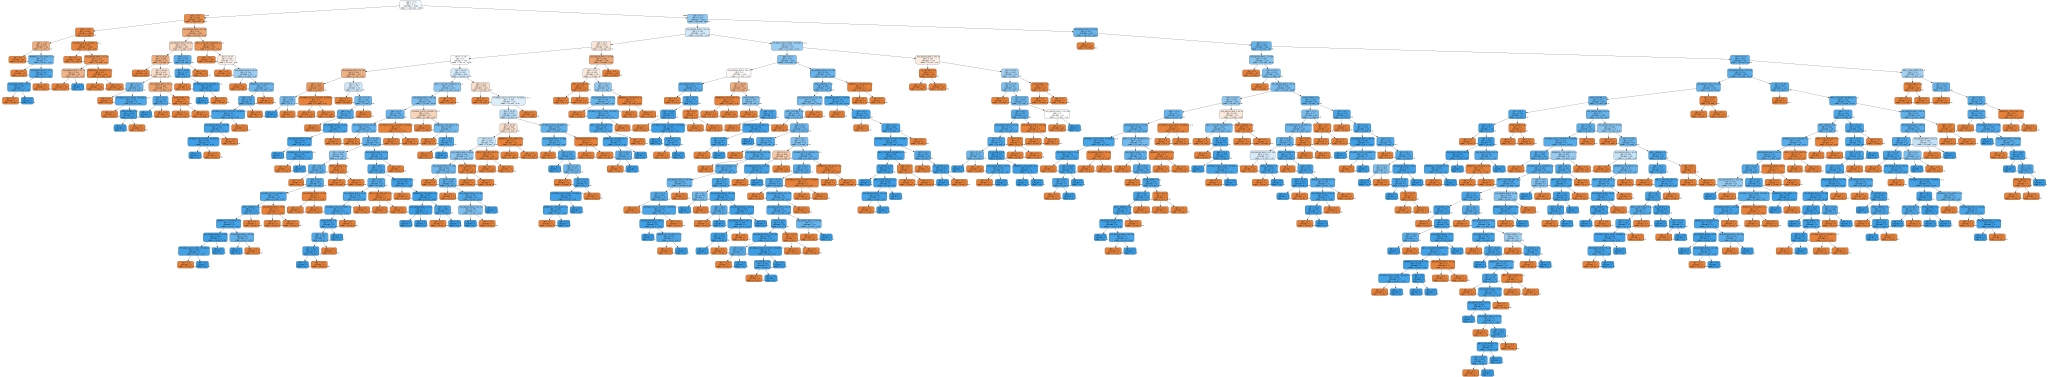

In [18]:
dot_data = tree.export_graphviz(tree_model, out_file=None,
                                feature_names=train_X.columns,
                                filled=True, rounded=True,
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

As per a tree visualisation above, the most important feature for decision tree model is age. It is used multiple times to split the data. The older the person, the more likely it will have a stroke. Another commonly used variables are: bmi, avg_glucose_level. Other factors are of lesser significance. Going from root to less/more likely child, the smallest stroke possibility has person of age between 1.36yo and 37.5yo, who doesn't smoke, where the most likely for a stroke is person older than 77.5yo, with avg_glucose_level over 103.445, not self-employed, with bmi between 32.25 and 33.15.

In [19]:
pred = tree_model.predict(test_X)
pred_bin = pred > 0.5
print("Accuracy:", accuracy_score(y_true = test_Y, y_pred = pred_bin))
print("ROC AUC Score:", roc_auc_score(y_true = test_Y, y_score = pred))
print(confusion_matrix(y_true = test_Y, y_pred = pred_bin))

Accuracy: 0.9246987951807228
ROC AUC Score: 0.5733573260349547
[[912  35]
 [ 40   9]]


The model performs worse than saying no-stroke at all time, but much better than linear regression. The main difference is at false-negative's - we only have around 19% probability on detecting stroke when one indeed has a stroke, which is really bad for us. It is also worse than in the case of linear-regression.